In [19]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

In [23]:
# module level imports
import sys
sys.path.append("..")

from src.distributions import log_gaussian
from src.utils import logsumexp

In [4]:
def sample(mu, var, nb_samples=500):
    """
    Return a tensor of (nb_samples, features), sampled
    from the parameterized gaussian.
    :param mu: torch.Tensor of the means
    :param var: torch.Tensor of variances (NOTE: zero covars.)
    """
    out = []
    for i in range(nb_samples):
        out += [
            torch.normal(mu, var.sqrt()).unsqueeze(0)
        ]
    return torch.cat(out, dim=0)

In [5]:
# generate some clusters
cluster1 = sample(
    torch.Tensor([2.5, 2.5]),
    torch.Tensor([1.2, .8])
)

cluster2 = sample(
    torch.Tensor([7.5, 7.5]),
    torch.Tensor([.75, .5])
)

cluster3 = sample(
    torch.Tensor([8, 1.5]),
    torch.Tensor([.6, .8])
)

In [6]:
def plot_2d_sample(sample):
    sample_np = sample.numpy()
    x = sample_np[:, 0]
    y = sample_np[:, 1]
    plt.scatter(x, y)

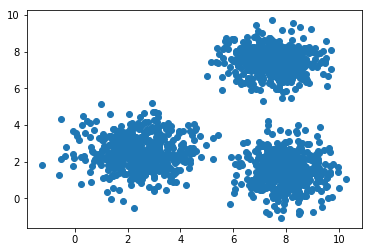

In [8]:
# create the dummy dataset, by combining the clusters.
X = torch.cat([cluster1, cluster2, cluster3])
plot_2d_sample(X)

In [9]:
def initialize(data, k, var=1):
    """
    Randomly initialize the parameters for `k` gaussians.
    :param data: design matrix (examples, features)
    :param k: number of gaussians
    :param var: initial variance
    """
    # choose k points from data to initialize means
    m = data.size(0)
    idxs = torch.from_numpy(np.random.choice(m, k, replace=False))
    mu = data[idxs]

    # uniform sampling for means and variances
    var = torch.Tensor(k, d).fill_(var)
    
    # uniform prior
    pi = torch.empty(k).fill_(1. / k)

    return mu, var, pi

In [188]:
def get_likelihoods(X, mu, logvar):
    """
    Compute the likelihood of each data point under each gaussians.
    :param X: design matrix (examples, features)
    :param mu: the component means (K, features)
    :param logvar: the component log-variances (K, features)
    :return likelihoods: (K, examples)
    """
    
    # get feature-wise log-likelihoods (K, examples, features)
    log_likelihoods = log_gaussian(
        X[None, :, :], # (1, examples, features)
        mu[:, None, :], # (K, 1, features)
        logvar[:, None, :] # (K, 1, features)
    )
    
    # sum over the feature dimension
    log_likelihoods = log_likelihoods.sum(-1)

    return log_likelihoods

In [27]:
def get_posteriors(likelihoods):
    """
    Calculate the the posterior probabities log p(z|x), assuming a uniform prior over
    components(for this step only).
    :param likelihoods: the relative likelihood p(x|z), of each data point under each mode (K, examples)
    :return: the log posterior p(z|x) (K, examples)
    """
    posteriors = likelihoods - logsumexp(likelihoods, dim=0, keepdim=True)
    return posteriors

In [32]:
likelihoods = torch.randn(10, 100)
posteriors = get_posteriors(likelihoods)
print(posteriors.exp().sum(0))

tensor([ 3.3359,  6.8767,  4.2581,  5.9175,  2.3680,  3.4581,  2.9684,  2.4046,
        11.3728,  7.6097,  2.7494,  6.8372,  9.1883,  3.1452, 10.4252,  3.5768,
         3.8808,  2.4397, 27.6110,  4.6831,  2.6726,  3.2711,  5.0775,  2.5691,
         5.1226,  2.6201,  7.4613,  8.1793,  3.1027,  3.5669,  2.8636,  8.0347,
         4.9587,  6.6964, 11.8860,  1.8992,  2.0180,  3.7775, 31.0440,  1.8111,
         5.1011,  4.2866,  3.0289,  5.1963,  3.8768,  2.2666,  5.0404,  6.0804,
         2.2093,  1.5135,  2.4694, 28.0361,  3.2484,  4.4592,  4.0992, 11.8896,
         2.6240,  2.7202,  2.5344,  5.5085,  7.6920,  1.7211,  5.4193,  4.2131,
         2.1109,  3.6617,  7.4225,  3.8543,  5.3288, 13.3959,  1.7182,  5.3707,
         4.3909,  3.4397,  1.4514,  3.5983,  3.1201,  2.1052,  4.1196,  5.0301,
         6.8962,  7.4928,  8.2259,  5.6785,  4.8188,  3.9142,  4.1757,  3.0225,
         6.1034,  1.9901,  4.4447,  2.5044,  2.3929,  4.7860,  4.8784,  6.3385,
         2.5558,  3.9737,  6.3569, 19.60

In [191]:
def get_parameters(X, posteriors, eps=1e-6):
    """
    :param X: design matrix (examples, features)
    :param posteriors: the posterior probabilities p(z|x) (K, examples)
    :returns mu, logvar, pi: (K, features) , (K, features) , (K)
    """
    
    # compute `N_k` the proxy "number of points" assigned to each distribution.
    K = posteriors.size(0)
    N_k = torch.sum(posteriors, dim=1) + eps # (K)
    N_k = N_k.view(K, 1, 1)
    
    # tile X on the `K` dimension
    X = X.unsqueeze(0).repeat(K, 1, 1)
    
    # get the means by taking the weighted combination of points
    mu = posteriors.unsqueeze(1) @ X # (K, 1, features)
    mu = mu / N_k
    
    # compute the diagonal covar. matrix, by taking a weighted combination of
    # the each point's square distance from the mean
    A = X - mu
    var = posteriors.unsqueeze(1) @ (A ** 2) # (K, 1, features)
    var = var / N_k
    
    # recompute the mixing probabilities
    m = X.size(1) # nb. of training examples
    pi = N_k / N_k.sum()
    
    return mu.squeeze(1), var.squeeze(1), pi.view(-1)

In [193]:
def get_density(mu, var, pi, N=50, X_range=(0, 5), Y_range=(0, 5)):
    """ Get the mesh to compute the density on. """
    X = np.linspace(*X_range, N)
    Y = np.linspace(*Y_range, N)
    X, Y = np.meshgrid(X, Y)
    
    # get the design matrix
    points = np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1)
    points = Variable(torch.from_numpy(points).float())
    
    # compute the densities under each mixture
    P = get_k_likelihoods(points, mu, var)

    # sum the densities to get mixture density
    Z = torch.sum(P, dim=0).data.numpy().reshape([N, N])
    
    return X, Y, Z

In [194]:
def plot_density(X, Y, Z, i=0):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
                    cmap=cm.inferno)
    cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.inferno)

    # adjust the limits, ticks and view angle
    ax.set_zlim(-0.15,0.2)
    ax.set_zticks(np.linspace(0,0.2,5))
    ax.view_init(27, -21)
#     plt.savefig('fig_{}.png'.format(i), dpi=400, bbox_inches='tight')
    plt.show()

torch.Size([3, 2])


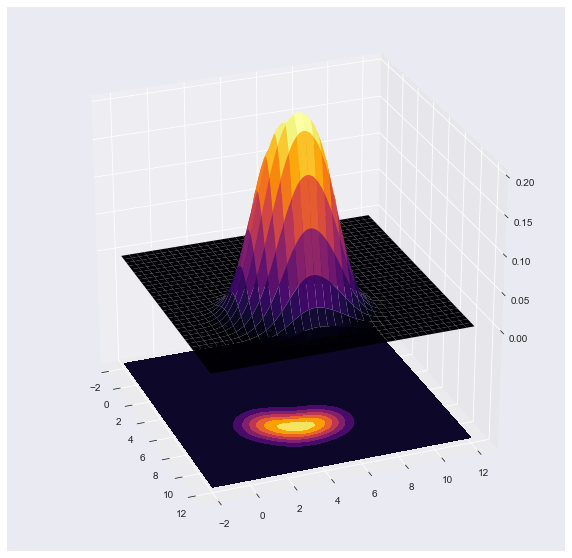

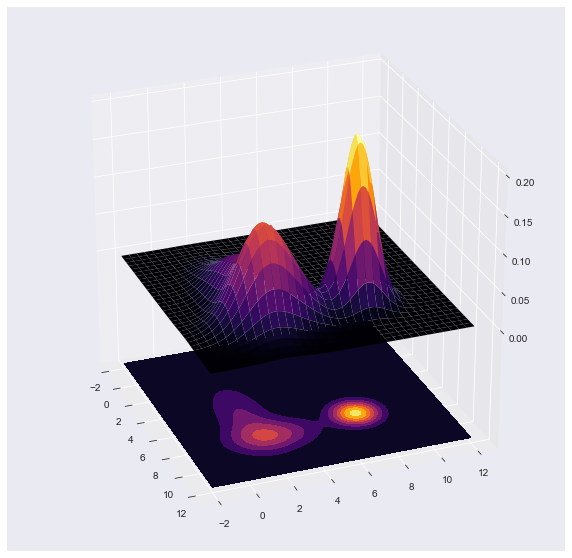

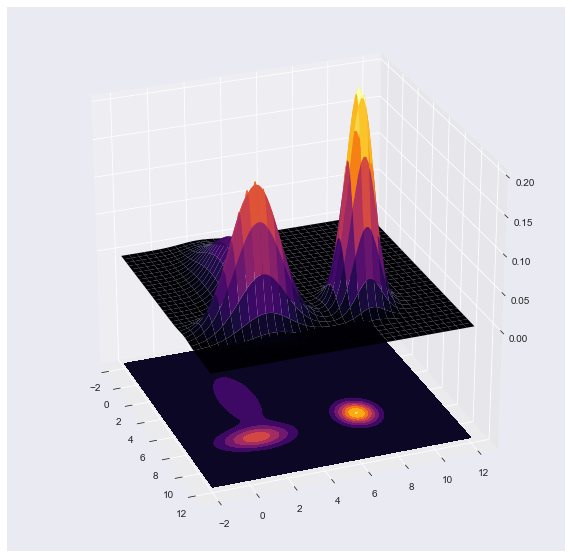

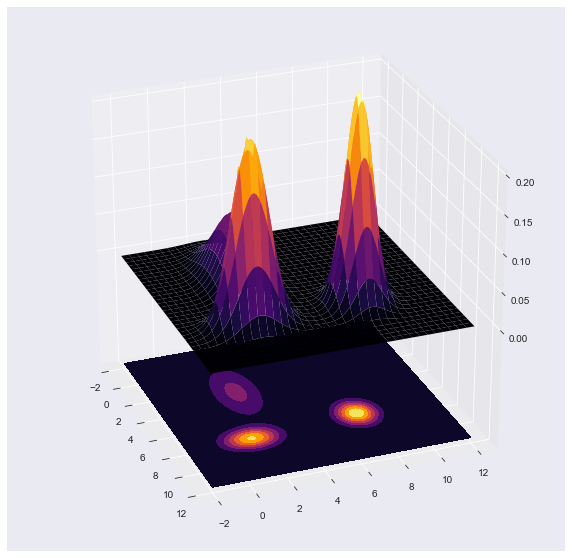

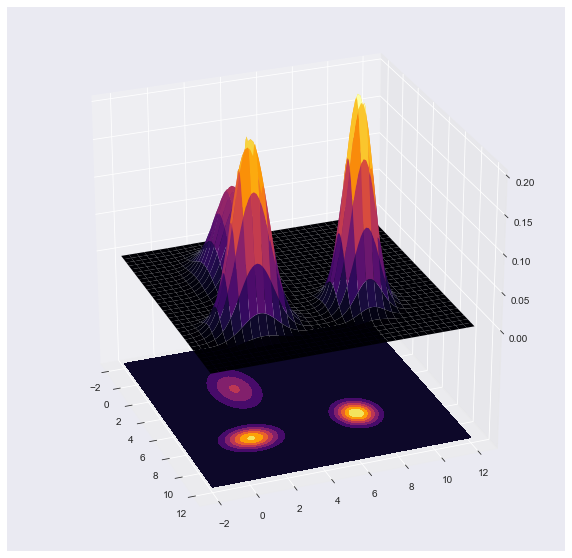

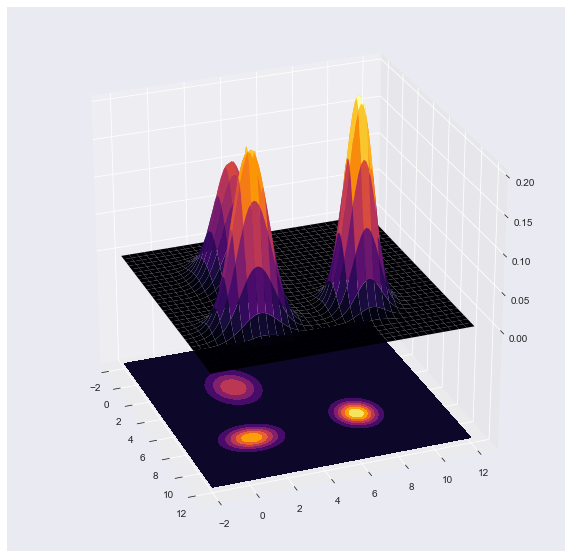

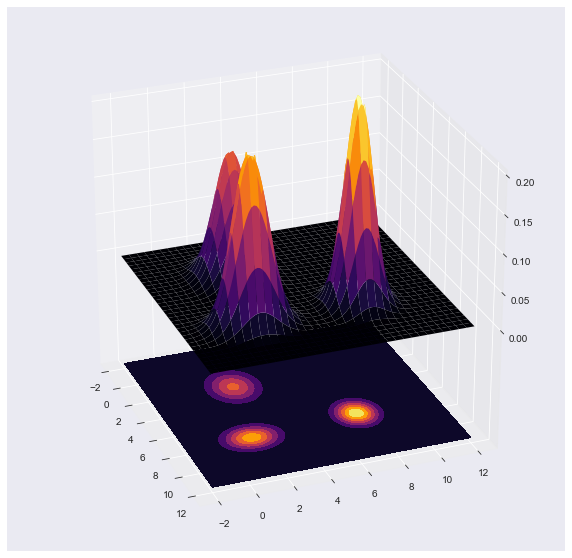

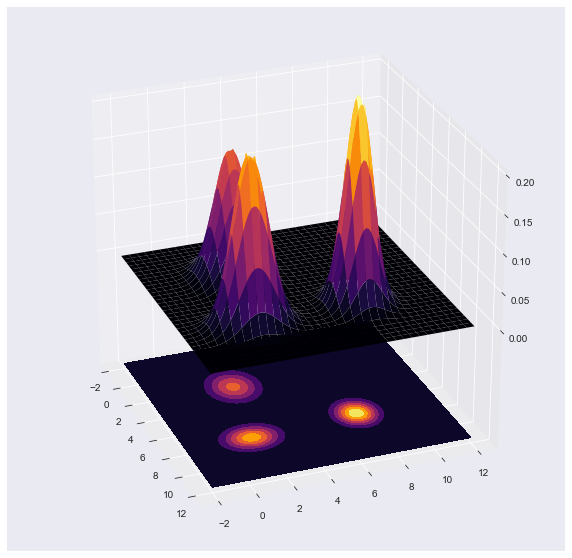

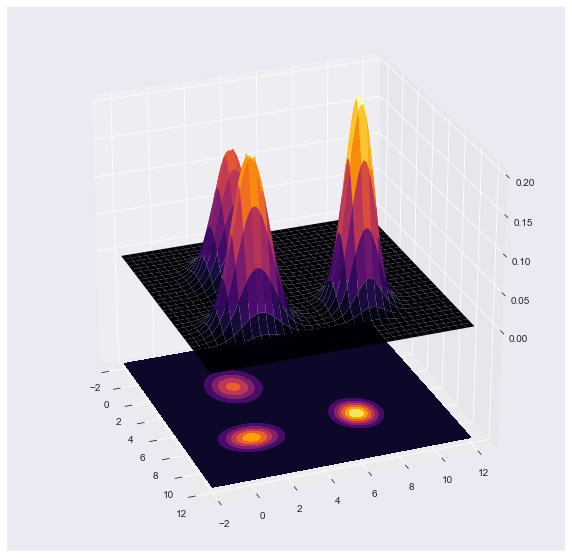

In [197]:
# training loop
k = 3
d = 2
nb_iters = 1000

data = Variable(X)
mu, var, pi = initialize(data, k, var=1)
print(mu.size())

prev_cost = float('inf')
thresh = 1e-4
for i in tqdm(range(nb_iters)):
    # get the likelihoods p(x|z) under the parameters
    P = get_k_likelihoods(data, mu, var)
    
    # plot!
    plot_density(*get_density(mu, var, pi, N=100, X_range=(-2, 12), Y_range=(-2, 12)), i=i)
    
    # compute the "responsibilities" p(z|x)
    gamma = get_posteriors(P)
    
    # compute the cost and check for convergence
    cost = log_likelihood(P, pi)
    diff = prev_cost - cost
    if torch.abs(diff).data[0] < thresh:
        break
    prev_cost = cost
    
    # re-compute parameters
    mu, var, pi = get_parameters(data, gamma)

In [198]:
print(mu)
print(var)
print(pi)

Variable containing:
 7.4991  7.5048
 7.9829  1.5581
 2.5327  2.5289
[torch.FloatTensor of size 3x2]

Variable containing:
 0.6778  0.5028
 0.5765  0.8558
 1.1345  0.7505
[torch.FloatTensor of size 3x2]

Variable containing:
 0.3333
 0.3337
 0.3330
[torch.FloatTensor of size 3]



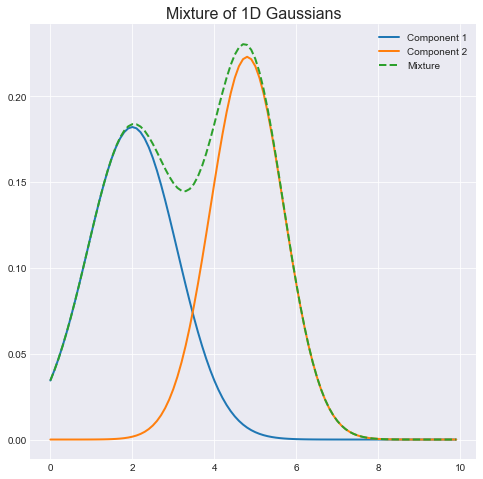

In [163]:
x = np.arange(0, 10, 0.1)
y1 = multivariate_normal.pdf(x, mean=2, cov=1.2)
y2 = multivariate_normal.pdf(x, mean=4.8, cov=0.8)
sns.set_style("darkgrid")
plt.figure(figsize=(8, 8))
plt.plot(x, y1/2, linewidth=2)
plt.plot(x, y2/2, linewidth=2)
plt.plot(x, (y1+y2)/2, linewidth=2, ls="--")
# plt.ylabel('f(x)', fontsize=14)
# plt.xlabel('x', fontsize=14)
plt.title("Mixture of 1D Gaussians", fontsize=16)
plt.legend(['Component 1', 'Component 2', 'Mixture'])
plt.savefig('mixture.png', dpi=400)
plt.show()
# print(a.size())